# Notas al modelo

In [51]:
# Object connections and constants
from src.connect_db import client_influx
from src.connect_db import client_df
from src.connect_db import client_mongo

# libraries from python 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

--- 
#### Datos de clima Eólica (input)

In [52]:
df=client_df
q_str=''' SELECT * FROM "Clima"  WHERE time > now()-3d'''
res=df.query(q_str)

In [53]:
points=res.items()
points=list(points)
clima=points[0][1]
clima.shape

(71, 526)

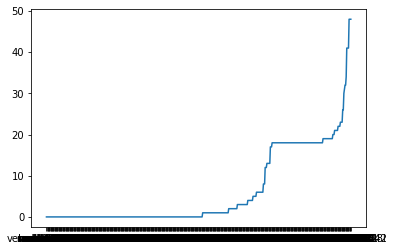

In [261]:
plt.plot(clima.isna().sum().sort_values())

In [54]:
col_velmedia=[ele for ele in clima.columns if ele.split('-')[0]=='velmedia']
clima_velmedia=clima[[*col_velmedia]]
clima_velmedia.shape

(71, 134)

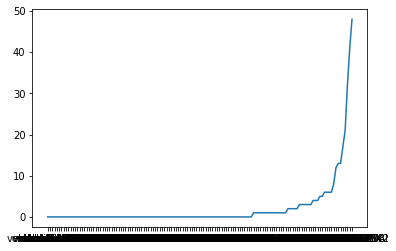

In [263]:
plt.plot(clima_velmedia.isna().sum().sort_values())

In [55]:
clima_velmedia=clima_velmedia.drop(['velmedia'],axis=1)

In [56]:
rename={old:old.split('-')[-1] for old in clima_velmedia}
clima_velmedia=clima_velmedia.rename(columns=rename)

In [57]:
clima_velmedia=clima_velmedia.dropna(axis='columns')
clima_velmedia.shape

(71, 86)

---
#### Datos de generación eólica (output)

In [58]:
df=client_df
q_str=''' SELECT * FROM "Generación T.Real eólica"  WHERE time > now()-3d'''
res=df.query(q_str)

In [59]:
points=res.items()
points=list(points)
g_eo=points[0][1]
g_eo.shape

(219, 2)

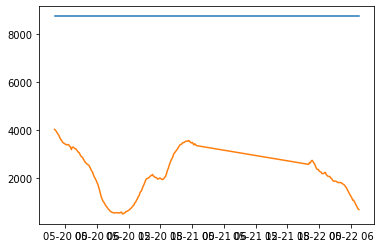

In [60]:
plt.plot(g_eo)

---
#### Modelo de predicción

In [442]:
data=clima_velmedia.join(g_eo)
data=data.drop(['geo_id'],axis=1)
data.shape

(59, 89)

In [443]:
data=data.dropna()
data.shape

(27, 89)

In [444]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [445]:
y=data['value']
X=data[[*[col for col in data.columns if col!='value']]]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

regr = MLPRegressor(hidden_layer_sizes=120,activation='logistic',
                    random_state=1, max_iter=500,solver='lbfgs').fit(X_train, y_train)

y_predict=regr.predict(X_test)

In [446]:
regr.score(X_test, y_test)

-0.1619529804240858

In [452]:
y_predict=pd.DataFrame(y_predict).set_index(X_test.index)

In [455]:
X_test.index

DatetimeIndex(['2020-05-20 15:00:00+00:00', '2020-05-20 12:00:00+00:00',
               '2020-05-20 16:00:00+00:00', '2020-05-20 01:00:00+00:00',
               '2020-05-20 21:00:00+00:00', '2020-05-20 08:00:00+00:00',
               '2020-05-20 18:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

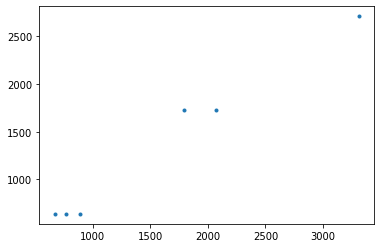

In [279]:
plt.plot(y_test,y_predict,'.')

In [280]:
print(clima_velmedia.index.min(),'-', clima_velmedia.index.max())

2020-05-18 14:00:00+00:00 - 2020-05-20 21:00:00+00:00


In [281]:
clima_velmedia.shape

(56, 90)

<Figure size 432x288 with 0 Axes>

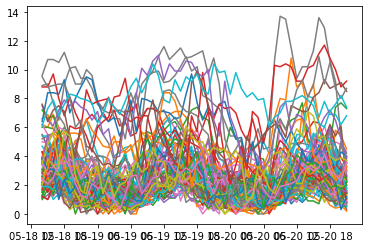

<Figure size 432x288 with 0 Axes>

In [282]:
plt.plot(clima_velmedia)
plt.figure()

In [283]:
db=client_mongo.ereal_collections
estaciones=list(db.estaciones.find({},{'_id':0,'indicativo':1,'latitud':1,'longitud':1}))


In [284]:
estaciones_k=np.array([[ int(ele['latitud'][:-1]) , 
               (-1 if ele['longitud'][-1]=='W' else 1)*int(ele['longitud'][:-1]) ] for ele in estaciones])

---
##### Cluster the meteorology stations

In [387]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20, random_state=0).fit(estaciones_k)

<Figure size 432x288 with 0 Axes>

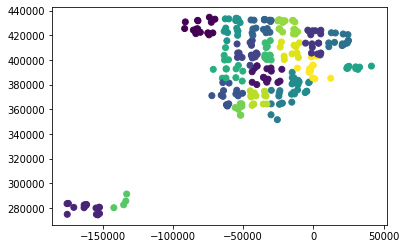

<Figure size 432x288 with 0 Axes>

In [388]:
cluster=kmeans.predict(estaciones_k)
plt.scatter(estaciones_k.T[1],estaciones_k.T[0],c=list(cluster))
plt.figure()

In [389]:
lat=[int(ele['latitud'][:-1]) for ele in estaciones]
lon=[(-1 if ele['longitud'][-1]=='W' else 1)*int(ele['longitud'][:-1]) for ele in estaciones]
indicativo=[ele['indicativo'] for ele in estaciones]

df_estaciones=pd.DataFrame(data={'lat':lat,'lon':lon,'indicativo':indicativo,'cluster':list(cluster)})
df_clima_est=df_estaciones.loc[df_estaciones['indicativo'].isin(list(clima_velmedia.columns))]

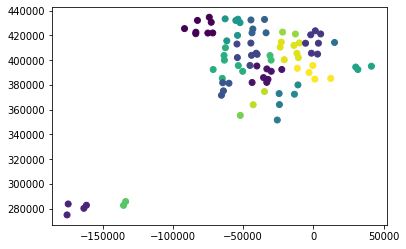

In [390]:
plt.scatter(df_clima_est['lon'],df_clima_est['lat'],c=df_clima_est['cluster'])

In [427]:
df_clima_est=df_estaciones.loc[df_estaciones['indicativo'].isin(list(clima_velmedia.columns))]
len(df_clima_est.index)

84

In [436]:
var1=list(df_clima_est.indicativo)
var2=list(clima_velmedia.columns)

In [439]:
[var for var in var2 if var not in var1]

['1109X', '5514Z', '9574B', 'C419L']

In [441]:
db= client_mongo.ereal_collections
estaciones=list(db.estaciones.find({},{'_id':0,'indicativo':1}))
estaciones

[{'indicativo': '0252D'},
 {'indicativo': '0076'},
 {'indicativo': '0200E'},
 {'indicativo': '0201D'},
 {'indicativo': '0149X'},
 {'indicativo': '0229I'},
 {'indicativo': '0255B'},
 {'indicativo': '0367'},
 {'indicativo': '0370B'},
 {'indicativo': '0372C'},
 {'indicativo': '0324A'},
 {'indicativo': '0016A'},
 {'indicativo': '0002I'},
 {'indicativo': '1387E'},
 {'indicativo': '1387'},
 {'indicativo': '1393'},
 {'indicativo': '1351'},
 {'indicativo': '1400'},
 {'indicativo': '1437O'},
 {'indicativo': '1473A'},
 {'indicativo': '1428'},
 {'indicativo': '1475X'},
 {'indicativo': '1212E'},
 {'indicativo': '1283U'},
 {'indicativo': '1210X'},
 {'indicativo': '1331A'},
 {'indicativo': '1207U'},
 {'indicativo': '1208A'},
 {'indicativo': '1208H'},
 {'indicativo': '1208'},
 {'indicativo': '1183X'},
 {'indicativo': '1249I'},
 {'indicativo': '1249X'},
 {'indicativo': '1221D'},
 {'indicativo': '1542'},
 {'indicativo': '1082'},
 {'indicativo': '1078I'},
 {'indicativo': '1055B'},
 {'indicativo': '1057B

In [325]:
cv_7=clima_velmedia[[*list(df_clima_est.loc[df_clima_est['cluster']==7].index)]]

In [326]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
model=VAR(cv_1)
results = model.fit(maxlags=5, ic='aic')

/home/ytorres/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [328]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, May, 2020
Time:                     02:03:21
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                   -1.36725
Nobs:                     51.0000    HQIC:                  -9.04385
Log likelihood:           100.757    FPE:                0.000136299
AIC:                     -13.7915    Det(Omega_mle):     1.21549e-06
--------------------------------------------------------------------
Results for equation 3260B
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            1.931778         1.663294            1.161           0.245
L1.3260B         0.888625         0.332825            2.670           0.008
L1.4121          0.033266         0.420869            0.079           0.937
L1.4

In [298]:
results.predict()

In [365]:
from statsmodels.tsa.api import SARIMAX

sarimax_mod = SARIMAX(cv_7, order=((1,24),0, 0), trend='n')
sarimax_res = sarimax_mod.fit()
sarimax_res.summary()


/home/ytorres/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/home/ytorres/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      0149X   No. Observations:                   56
Model:             SARIMAX([1, 24], 0, 0)   Log Likelihood                 -52.344
Date:                    Thu, 21 May 2020   AIC                            110.688
Time:                            03:49:24   BIC                            116.764
Sample:                        05-18-2020   HQIC                           113.044
                             - 05-20-2020                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4923      0.078      6.322      0.000       0.340       0.645
ar.L24         0.5025      0.078      6.435      0.000       0.349       0.656
sigma2         0.2890      0.054      5.305      0.000       0.182       0.396
===================================================================================
Ljung-Box (Q):                       23.94   Jarque-Bera (JB):                25.65
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               2.25   Skew:                             1.00
Prob(H) (two-sided):                  0.09   Kurtosis:                         5.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [366]:
pred=sarimax_res.forecast(24)

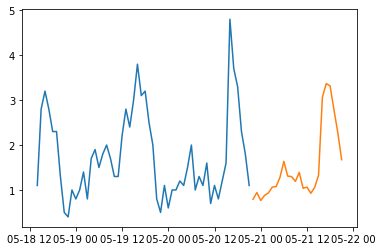

In [367]:
plt.plot(cv_7)
plt.plot(pred)

In [381]:
pred=pred.rename(cv_7.columns[0])
pred.to_csv('temp.csv')


In [330]:
mod = sm.tsa.VARMAX(cv_7, order=(5,0), trend='n')
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/home/ytorres/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


ValueError: Only gave one variable to VAR

<Figure size 432x288 with 0 Axes>

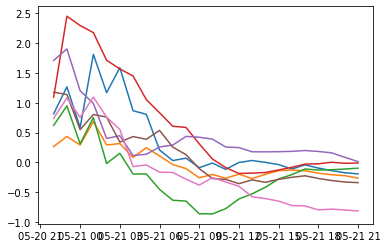

<Figure size 432x288 with 0 Axes>

In [341]:
plt.plot(res.forecast(24))
plt.figure()

In [358]:
pred=pd.read_csv('data/pred_wind_16.csv')
pred=pred.rename({'Unnamed: 0': 'time'}, axis='columns')
pred=pred.set_index('time')
x=pd.DataFrame()
x=pred

In [359]:
pred=pd.read_csv('data/pred_wind_17.csv')
pred=pred.rename({'Unnamed: 0': 'time'}, axis='columns')
pred=pred.set_index('time')
x=x.join(pred,how='inner')

<Figure size 432x288 with 0 Axes>

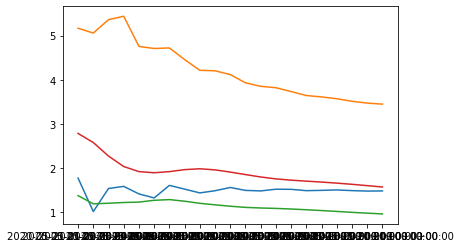

<Figure size 432x288 with 0 Axes>

In [363]:
plt.plot(x)
xtics
plt.figure()

In [29]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
import contextily as ctx

In [30]:
df = pd.read_csv('data/estaciones.csv')
df['lat']=df['lat'].div(10000)
df['lon']=df['lon'].div(10000)

In [31]:
gdf = geopandas.GeoDataFrame(
   df, geometry=geopandas.points_from_xy(df.lon, df.lat))


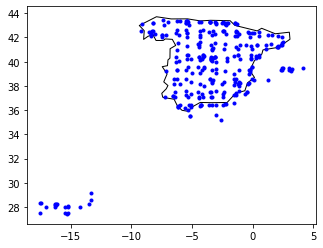

In [28]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# We restrict to South America.
ax = world[world.name == 'Spain'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='blue',marker=".")

plt.show()


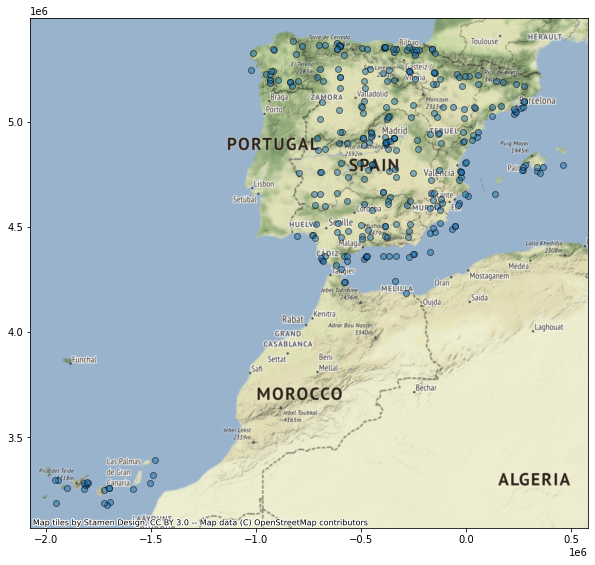

In [40]:
df = pd.read_csv('data/estaciones.csv')
df['lat']=df['lat'].div(10000)
df['lon']=df['lon'].div(10000)
gdf = geopandas.GeoDataFrame(
   df, geometry=geopandas.points_from_xy(df.lon, df.lat),crs="EPSG:4326")
df = gdf.to_crs(epsg=3857)
ax = df.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax)

In [44]:
from src.connect_db import client_mongo
import numpy as np
from sklearn.cluster import KMeans

db=client_mongo.ereal_collections
estaciones=list(db.estaciones.find({},{'_id':0,'indicativo':1,'latitud':1,'longitud':1}))
estaciones_k=np.array( [ [ int(ele['latitud'][:-1]) ,
                          (-1 if ele['longitud'][-1]=='W' else 1)*int(ele['longitud'][:-1]) ]
                        for ele in estaciones ] )

     # aqui es donde se define el número de clusters
kmeans = KMeans(n_clusters=20, random_state=0).fit(estaciones_k)

cluster=kmeans.predict(estaciones_k)
df=pd.DataFrame({'cluster':cluster,
                 'Lat':estaciones_k.T[0]/10000.0,
                 'Lon':estaciones_k.T[1]/10000.0})


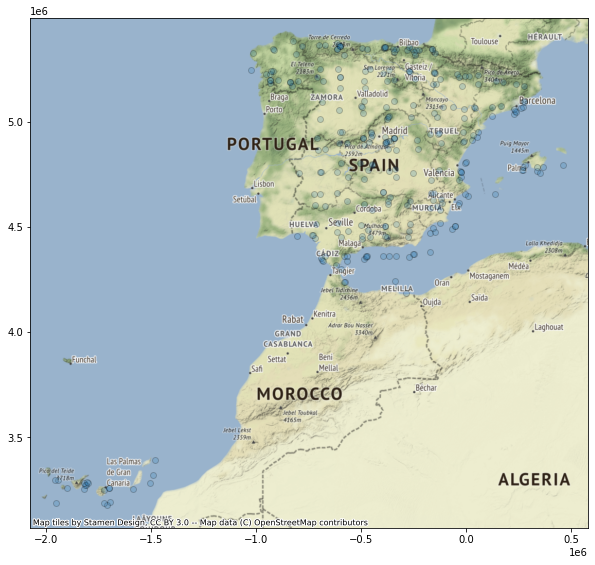

In [50]:
gdf = geopandas.GeoDataFrame(
   df, geometry=geopandas.points_from_xy(df.Lon, df.Lat),crs="ETRS89")
df = gdf.to_crs(epsg=3857)
ax = df.plot(figsize=(10, 10), alpha=0.2, edgecolor='k')
ctx.add_basemap(ax)
plt.savefig('loquesea.png')